# Analysis of the obtained scores

## Env setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [76]:
import matplotlib.pyplot as plt
import json
import matplotlib.pyplot as plt
import numpy as np
import evaluate
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer, util

## Manual Scores Analysis

Here you can find an analysis of the scores obtained by the manual evaluation of the generated code.
The scores are in range [1,5] where 1 is the worst and 5 is the best. The code generated was evaluated by me based on the following criteria:
- **Overall Satisfaction**: If I were to be suggested this code while working on a project, how satisfied would I be with it?
- **Similarity**: How similar is the generated code to the original code?
- **Completeness**: With respect to the original code, how complete is the generated code? Does it include all the necessary parts?
- **Errors**: How many errors are present in the code? (The higher the score, the fewer the errors therefor the better).

Some more insight can be said about some metrics:
- **Similarity**: It was quite difficult to rate this metric. As a rule of thumb, if the generated code was accomplishing everything the original code was accomplishing I would rate it high regardless of other parts of the code. However, if the extra-parts were to introduce deviation or errors I would give a lower score.
- **Errors**: Scores 1-2 are for code that actively introduces code errors. Scores 3-4 are for code that has some minor errors but is mostly correct. Score 5 is for code that has no errors.


In [60]:
# Load data from JSON file
with open("manual_scores.json", "r") as f:
    data = json.load(f)

# Extract metrics
satisfaction = [entry["satisfaction"] for entry in data]
similarity = [entry["similarity"] for entry in data]
completeness = [entry["completeness"] for entry in data]
errors = [entry["errors"] for entry in data]


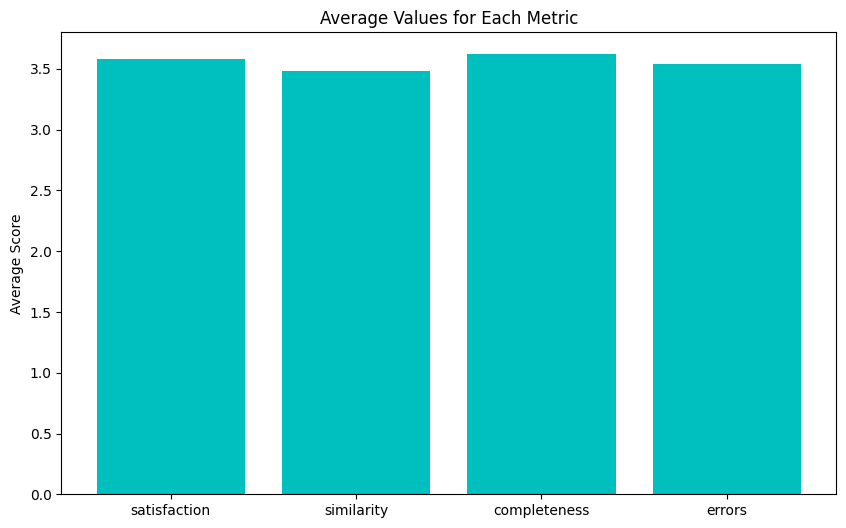

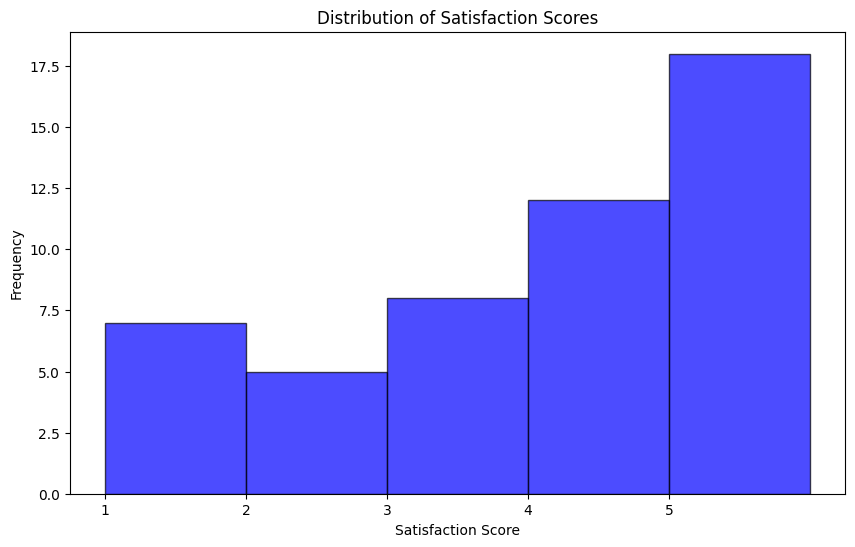

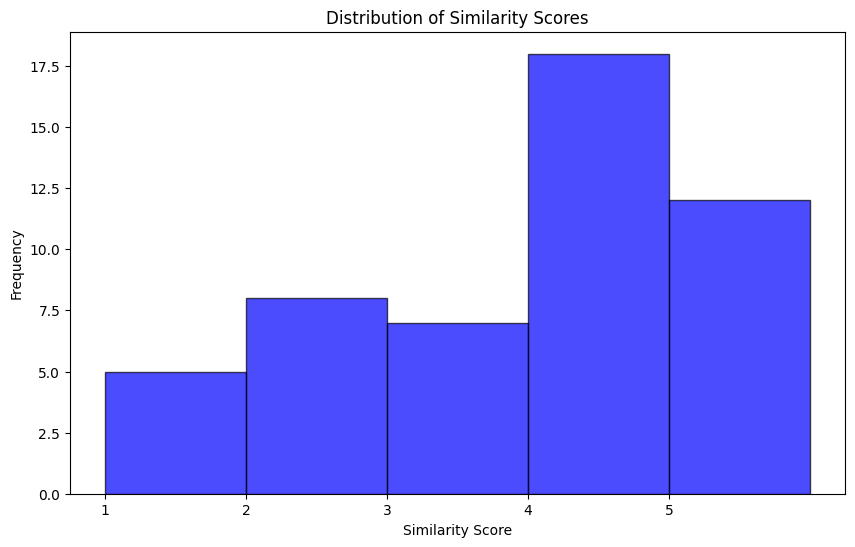

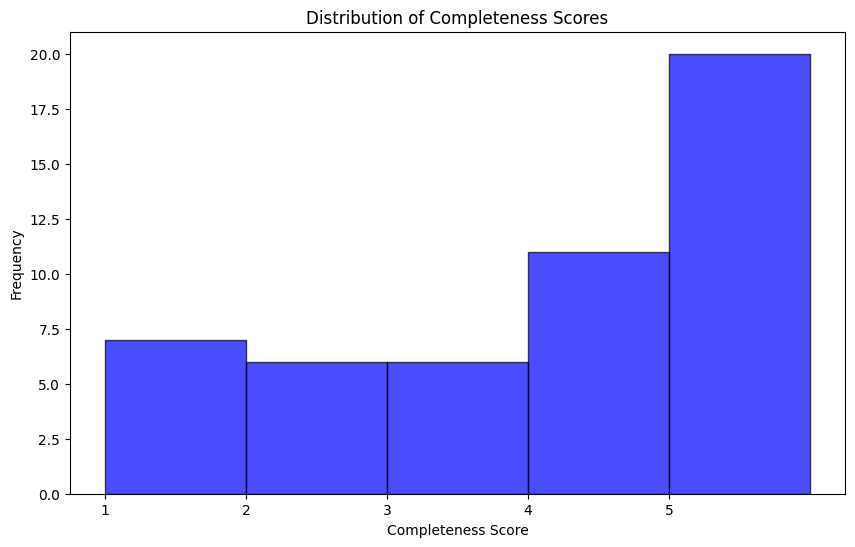

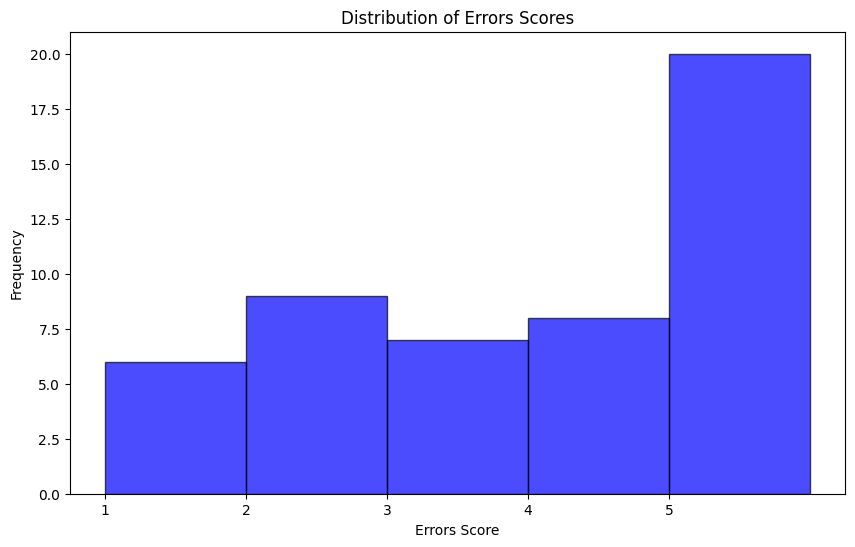

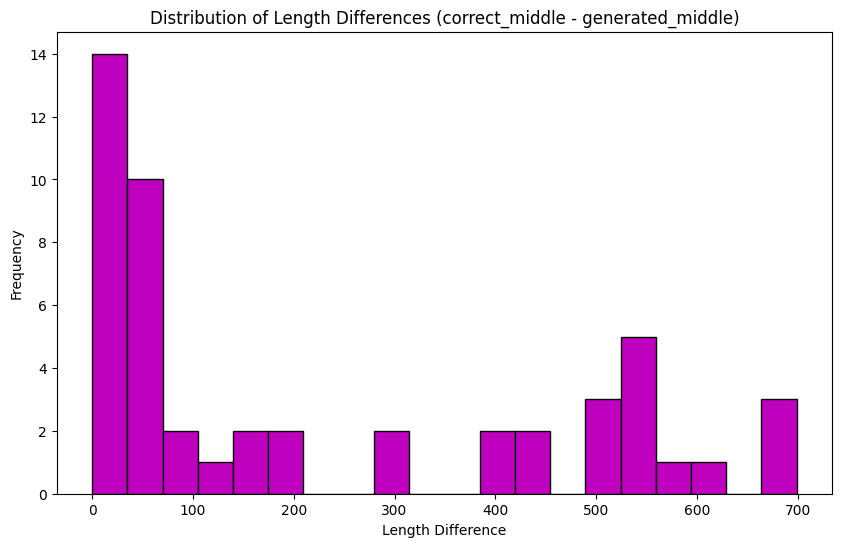

In [61]:
# Compute averages
average_scores = {
    "satisfaction": np.mean(satisfaction),
    "similarity": np.mean(similarity),
    "completeness": np.mean(completeness),
    "errors": np.mean(errors)
}

# Plot histogram of average values
plt.figure(figsize=(10, 6))
plt.bar(average_scores.keys(), average_scores.values(), color='c')
plt.title('Average Values for Each Metric')
plt.ylabel('Average Score')
plt.show()

# Histogram for each metric's distribution
metrics = {"satisfaction": satisfaction, "similarity": similarity, "completeness": completeness, "errors": errors}

for metric, values in metrics.items():
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=range(1, 7), alpha=0.7, color='b', edgecolor='black')
    plt.title(f'Distribution of {metric.capitalize()} Scores')
    plt.xlabel(f'{metric.capitalize()} Score')
    plt.ylabel('Frequency')
    plt.xticks(range(1, 6))
    plt.show()

# Additional analysis: Length difference between correct and generated middle
length_differences = [abs(len(entry["correct_middle"]) - len(entry["generated_middle"])) for entry in data]
plt.figure(figsize=(10, 6))
plt.hist(length_differences, bins=20, color='m', edgecolor='black')
plt.title('Distribution of Length Differences (correct_middle - generated_middle)')
plt.xlabel('Length Difference')
plt.ylabel('Frequency')
plt.show()

It is possible to see from this graph that qualitatevely speaking the model performed quite good.
All of the metrics present a high peak on either 4 or 5 stars out of 5, which is a good sign. The overall satisfaction is the most important metric and it is the one that has the highest peak on 5 stars.

Overall, all the metrics averaged around 3.5 stars. Interestingly enough, the model tends to output more text than neeed consistently.
It is clear in the lenght difference histogram in which there's a long left-tail with negative values. It was a feeling I had while evaluating the code and it is confirmed by the data.

## Automatic Scores Analysis

1. exact match
2. chrf
3. BLEU
4. Meteor
5. Levenshtein Distance
6. Precision-Recall-F1 score for the tokenized data (given the same tokenizer)
7.  Neural Sentence Embeddings similarities for finetuned models on code

Preparing the data...

In [62]:
out_data = json.load(open("model_outputs.json", "r"))
gold_answers = [entry["correct_middle"] for entry in out_data]
generated_answers = [entry["generated"] for entry in out_data]

### Exact Match

Quite simple, what is the percentage of the generated code that is exactly the same as the original code?

In [6]:
count = 0
for i in range(len(gold_answers)):
    if gold_answers[i] == generated_answers[i]:
        count += 1
print(f"Percentage of generated answers that are correct: {count / len(gold_answers) * 100:.2f}% ({count} out of {len(gold_answers)})")

Percentage of generated answers that are correct: 4.00% (2 out of 50)


Clearly the exact match metric does not reflect my own findings, not that I thought it would but it was specified as a requirement.

### ChrF

In [22]:
chrf_preds = [x for x in generated_answers]
chrf_refs = [[x] for x in gold_answers]
chrf = evaluate.load("chrf")
results = chrf.compute(predictions=chrf_preds, references=chrf_refs)
print(f"CHRF score: {results['score']:.4f}")

CHRF score: 37.5755


ChrF ranges from 0 to 100 (or 0 to 1).

With the ChrF metric we can see that things start to change. The score is still quite bad, but at least is it in a somewhat acceptable range. Still, the ChrF metric reflects the fact that most of the generated code is not the same as the original one. 
This is in line with my own expectation, as the model tends to generate more code than needed.

In [21]:
test_pred = ["I am student"]
test_ref = [["I am a student."]]

result_test = chrf.compute(predictions=test_pred, references=test_ref)
print(result_test)

{'score': 56.762006949159485, 'char_order': 6, 'word_order': 0, 'beta': 2}


### BLEU

In [25]:
# Bleu uses the same format as CHRF so we can reuse the same data
bleu = evaluate.load("bleu")
bleu_results = bleu.compute(predictions=chrf_preds, references=chrf_refs)
print(bleu_results)

{'bleu': 0.14053657801496994, 'precisions': [0.22520827734479978, 0.15472623263415963, 0.11792322562827948, 0.09493139176701204], 'brevity_penalty': 1.0, 'length_ratio': 2.936858721389108, 'translation_length': 3721, 'reference_length': 1267}


BLEU can range from 0 to 1 (or 0 to 100 when scaled).

The BLEU metrics performs quite bad. Indeed, BLEU is very similar to ChrF, but defined on words n-grams rather than characters. As such, there's no surprise that the BLEU metric is even lower than the ChrF metric.
Although it is notably difficult to get high scores in BLEU, this is far from acceptable. And once again does not correlate with my own findings.
As always, the disalignment in length is the main issue that drives down the score.

### METEOR

In [27]:
meteor = evaluate.load("meteor")
meteor_results = meteor.compute(predictions=generated_answers, references=gold_answers)
print(meteor_results)

[nltk_data] Downloading package wordnet to /home/gp-1108/nltk_data...
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/gp-1108/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /home/gp-1108/nltk_data...


{'meteor': 0.41534014897388255}


METEOR can range from 0 to 1 (or 0 to 100 when scaled).

The METEOR metric starts to get to little bit better. It is still quite low (3.5/5 starts is 0.7 relative score) but it is in a somewhat acceptable range. This is probably due to the fact that METEOR is a metric that poses more importance on the recall factor, therefore longer sentences are not penalized as much as in BLEU or ChrF.

### Levenshtein Distance

In [47]:
def levenshteinDistanceDP(token1, token2):
    """
    Calculate the Levenshtein distance between two tokens using dynamic programming.
    The Levenshtein distance is a measure of the similarity between two strings, 
    which we will refer to as the source string (token1) and the target string (token2). 
    The distance is the number of deletions, insertions, or substitutions required to 
    transform the source into the target.
    Args:
        token1 (str): The first token (source string).
        token2 (str): The second token (target string).
    Returns:
        int: The Levenshtein distance between the two tokens.
    """
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(token1)][len(token2)]

lev_dists = []
for i in range(len(gold_answers)):
    lev_dists.append(levenshteinDistanceDP(gold_answers[i], generated_answers[i]))

By itself the Levenshtein Distance is a very rough metric, which deals little to no information about the quality of the generated code.
This is due to the fact that it is heavily based on the length of the strings and would not correlate well with our answers which have been proved to be longer than the original code.

Let us see the distribution of the Levenshtein Distance compared to the length difference.

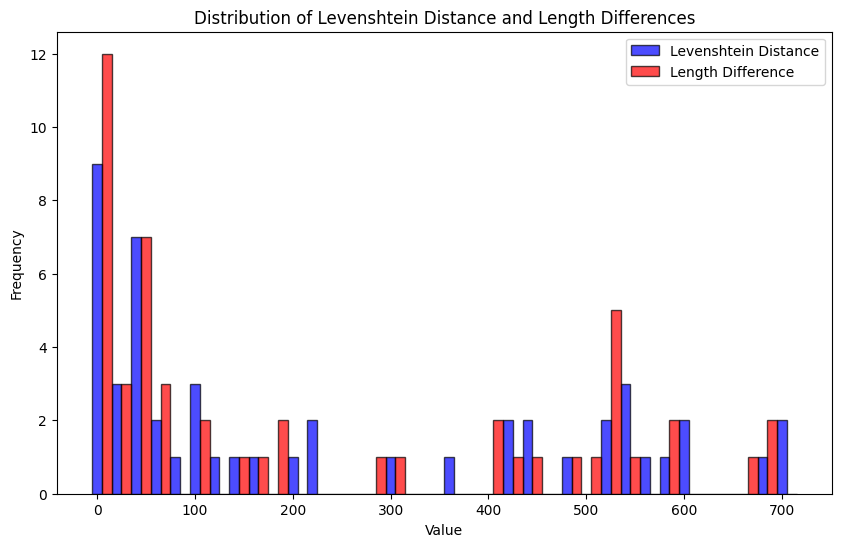

In [57]:
# Setting up for the histogram
bin_size = 20
length_differences = [abs(len(generated_answers[i]) - len(gold_answers[i])) for i in range(len(gold_answers))]
max_val = int(max(max(lev_dists), max(length_differences)))
bins = np.arange(0, max_val+bin_size, bin_size)

# Calculating histogram values for both distributions
lev_hist, _ = np.histogram(lev_dists, bins=bins)
length_hist, _ = np.histogram(length_differences, bins=bins)

# Width of each bar
bar_width = bin_size / 2

# Plotting in the same figure for comparison
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], lev_hist, width=bar_width, alpha=0.7, color='b', edgecolor='black', label='Levenshtein Distance')
plt.bar(bins[:-1] + bar_width, length_hist, width=bar_width, alpha=0.7, color='r', edgecolor='black', label='Length Difference')
plt.title('Distribution of Levenshtein Distance and Length Differences')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


As foreshadowed, the Levenshtein Distance is heavily correlated with the length difference. This is due to the fact that the Levenshtein Distance is based on the number of operations needed to transform one string into another. As such, the longer the strings, the more operations are needed and the higher the Levenshtein Distance.
Let's try to plot now the absolute difference between the Levenshtein Distance and the length difference.

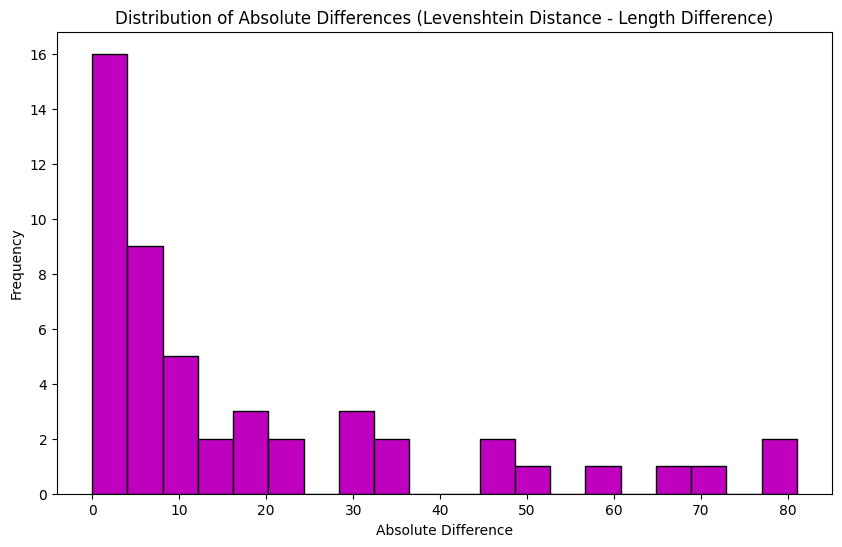

In [63]:
# Additional analysis: Length difference between correct and generated middle
lev_length_diff = [abs(lev_dists[i] - length_differences[i]) for i in range(len(lev_dists))]
plt.figure(figsize=(10, 6))
plt.hist(lev_length_diff, bins=20, color='m', edgecolor='black')
plt.title('Distribution of Absolute Differences (Levenshtein Distance - Length Difference)')
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.show()

The plot shows us two things:
* The Levenshtein difference is obviously correlated with the length difference.
* Many of the generated code snippets (once adjusted for the length difference) actually have a low score (meaning they are quite similar to the original code).

This is not by any means a good metrics, but further proves my insights that the model tends to generate more code than needed, but the code it generates is quite similar to the original code.

### Precision-Recall-F1 score for the tokenized data

In [65]:
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-coder-1.3b-base", trust_remote_code=True)
tokenized_gold = [tokenizer.tokenize(x) for x in gold_answers]
tokenized_gen = [tokenizer.tokenize(x) for x in generated_answers]

In [67]:
def get_precision_recall_f1(tokenized_gen: list[str], tokenized_gold: list[str]):
    """
    Calculate the precision, recall, and F1 score of the generated tokens compared to the gold tokens.
    Args:
        tokenized_gen (List[List[str]]): A list of lists of generated tokens.
        tokenized_gold (List[List[str]]): A list of lists of gold tokens.
    Returns:
        Tuple[float, float, float]: The precision, recall, and F1 score values.
    """
    total_precision = 0
    total_recall = 0

    for i in range(len(tokenized_gen)):
        gen_set = set(tokenized_gen[i])
        gold_set = set(tokenized_gold[i])
        intersection = gen_set.intersection(gold_set)
        
        total_precision += len(intersection) / len(gen_set) if len(gen_set) > 0 else 0
        total_recall += len(intersection) / len(gold_set) if len(gold_set) > 0 else 0

    precision = total_precision / len(tokenized_gen)
    recall = total_recall / len(tokenized_gold)

    # Calculating F1 score
    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0

    return precision, recall, f1_score

# Example usage
precision, recall, f1_score = get_precision_recall_f1(tokenized_gen, tokenized_gold)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Precision: 0.5752
Recall: 0.6112
F1 Score: 0.5927


Finally, out of all the metrics used so far, this is the one that mostly correlates with my own findings.
I think that this is due to the fact that the tokenized data allows for a more fair comparison between the generated code and the original code.

### Neural Sentence Embeddings

In [73]:
model = SentenceTransformer("flax-sentence-embeddings/st-codesearch-distilroberta-base")
gen_enc, gold_enc = model.encode(generated_answers), model.encode(gold_answers)
cosine_scores = util.pairwise_cos_sim(gen_enc, gold_enc)

/home/gp-1108/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


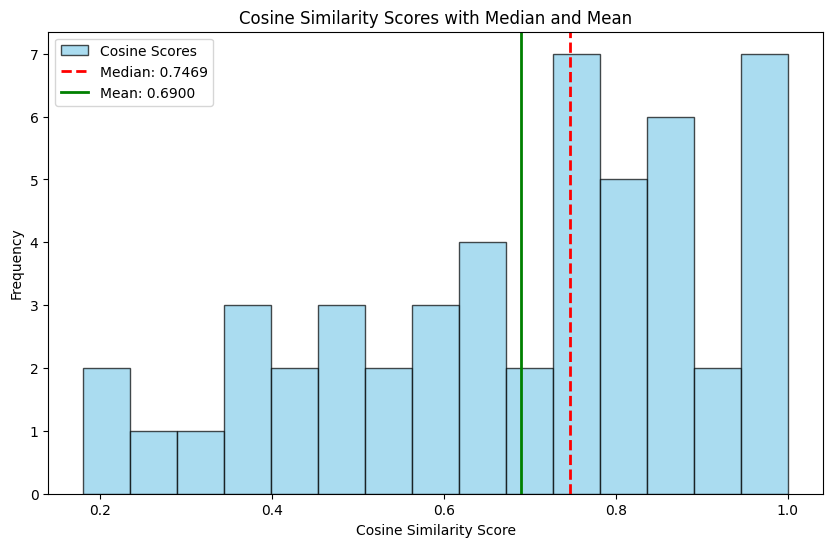

In [81]:
cosine_scores = np.array(cosine_scores)
median_value = np.median(cosine_scores)
mean_value = np.mean(cosine_scores)

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the histogram of cosine scores
plt.hist(cosine_scores, bins=15, color='skyblue', edgecolor='black', alpha=0.7, label='Cosine Scores')

# Plot the median as a vertical line
plt.axvline(median_value, color='red', linestyle='--', label=f'Median: {median_value:.4f}', linewidth=2)

# Plot the mean as a vertical line
plt.axvline(mean_value, color='green', linestyle='-', label=f'Mean: {mean_value:.4f}', linewidth=2)

plt.title('Cosine Similarity Scores with Median and Mean')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

I have reserved for last the metric that I thought since the beginning would reflect more accurately the quality of the generated code.
It is clear to see that the model is generating code similar to the true one. Not only that but the average and median similarity closely resemble the scores I gave to the code:
- Mean: ~0.7 (3.5/5)
- Median: ~0.75 (3.75/5)
My overall satisfaction mean was 3.5/5, therefore very close.